## Observations and Insights
1. There is a linear correlation between tumor volume in mm3 and weight of a mouse given Capomulin.
This is to be expected since tumor size would have an impact on the overall weight of the mouse.
2. Of the four analyzed "promising" drug regimens (Ramicane, Capomulin, Ceftamin, Infubinol), Ramicane and Capomulin both had positive effects with keeping tumor growth
from increasing or reducing tumor size in the sample.
3. While the study results appear to be controlled for gender, they weren't controlled for by age. Age is distributed
bimodal for the entire population and several populations lean towards using mainly younger or older mice. The placebo
seems to have been controlled for this. This could skew some results obtained about effectiveness.


In [46]:
# Install Dependencies
import pandas as pd
import scipy.stats as stat
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Set Data Paths
mouse_metadata_path = '../data/Mouse_metadata.csv'
study_results_path = '../data/study_results.csv'

# Load Data Into Pandas
mouse_metadata_df = pd.read_csv(mouse_metadata_path)
study_results_df = pd.read_csv(study_results_path)

study_data_df = pd.merge(study_results_df, mouse_metadata_df, how='left', on='Mouse ID')

study_data_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.0,0,Capomulin,Female,9,22
1,f932,0,45.0,0,Ketapril,Male,15,29
2,g107,0,45.0,0,Ketapril,Female,2,29
3,a457,0,45.0,0,Ketapril,Female,11,30
4,c819,0,45.0,0,Ketapril,Male,21,25


In [47]:
# Get duplicate values from study data
duplicate_mouse_row = study_data_df.duplicated(subset=['Mouse ID', 'Timepoint'])
duplicate_mouse_df = study_data_df[duplicate_mouse_row]
duplicate_mouse_id_list = duplicate_mouse_df['Mouse ID'].unique()

# Drop all mice that have duplicate study rows
study_data_df = study_data_df[~study_data_df['Mouse ID'].isin(duplicate_mouse_id_list)]

## Summary Statistics

In [48]:
# Get summary statistics
drug_summary_df = study_data_df.groupby('Drug Regimen')['Tumor Volume (mm3)'].agg(
    Mean_Tumor_Volume = np.mean,
    Median_Tumor_Volume = np.median,
    Variance_Tumor_Volume = np.var,
    Stdev_Tumor_Volume = np.std,
    SEM_Tumor_Voume = stat.sem
)

# Rename columns
drug_summary_df.rename(columns={
    'Mean_Tumor_Volume': 'Mean Tumor Volume',
    'Median_Tumor_Volume': 'Median Tumor Volume',
    'Variance_Tumor_Volume': 'Tumor Volume Variance',
    'Stdev_Tumor_Volume': 'Tumor Volume Stdev',
    'SEM_Tumor_Volume': 'Tumor Volume SEM'
}, inplace = True)

drug_summary_df

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Stdev,SEM_Tumor_Voume
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

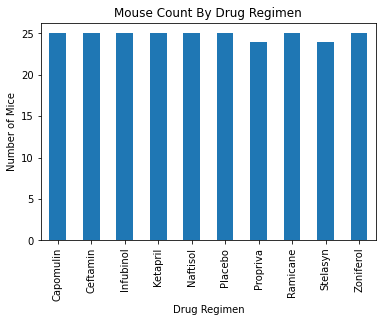

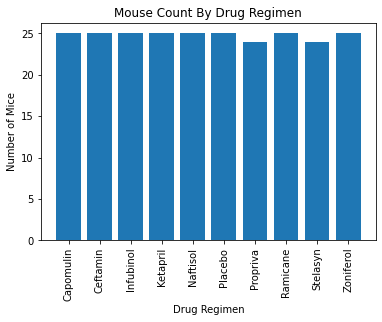

In [49]:
# Get unique mouse numbers per drug regimen
mice_per_trial = study_data_df.groupby('Drug Regimen')['Mouse ID'].nunique()

#plot using pandas
mice_per_trial.plot(kind='bar', rot=90, title='Mouse Count By Drug Regimen')
plt.xlabel('Drug Regimen')
plt.ylabel('Number of Mice')
plt.show()

# plot using matplotlib
plt.bar(mice_per_trial.index, mice_per_trial)
plt.xlabel('Drug Regimen')
plt.ylabel('Number of Mice')
plt.title('Mouse Count By Drug Regimen')
plt.xticks(rotation=90)
plt.show()

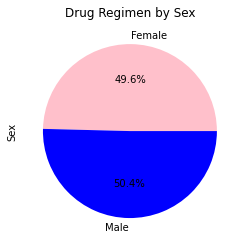

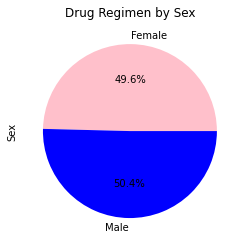

In [50]:
# Get unique mice count by sex
mice_gender = study_data_df.groupby('Sex')['Mouse ID'].nunique()

# plot using pandas
mice_gender.plot(kind = 'pie', title='Drug Regimen by Sex', autopct='%1.1f%%', colors=['pink', 'blue'])
plt.ylabel('Sex')
plt.show()

# plot using matplotlib
plt.pie(mice_gender, labels=['Female', 'Male'], autopct='%1.1f%%', colors=['pink', 'blue'])
plt.title('Drug Regimen by Sex')
plt.ylabel('Sex')
plt.show()

## Quartiles, Outliers, and Boxplots

In [51]:
# Filter data down to drugs with better results
filtered_drugs_df = study_data_df[study_data_df['Drug Regimen'].isin(['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin'])]

last_timepoint = filtered_drugs_df.groupby('Mouse ID')['Timepoint'].max()

filtered_drugs_df = filtered_drugs_df.merge(last_timepoint, how='inner', on=['Mouse ID', 'Timepoint'])
filtered_drugs_df.set_index('Mouse ID', inplace=True)

# Display all results
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(filtered_drugs_df)

,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
Mouse ID,,,,,,,
u153,0,45.000000,0,Ceftamin,Female,11,25
b447,0,45.000000,0,Ceftamin,Male,2,30
x226,0,45.000000,0,Ceftamin,Male,23,28
t573,0,45.000000,0,Ceftamin,Female,15,27
c326,5,36.321346,0,Infubinol,Female,18,25
w678,5,43.166373,0,Ramicane,Female,5,24
v339,5,46.250112,0,Infubinol,Male,20,26
m756,5,47.010364,1,Infubinol,Male,19,30
o813,5,45.699331,0,Infubinol,Male,24,28


In [52]:
drug_list = filtered_drugs_df['Drug Regimen'].unique()
plot_list = {}

# Loop through drug list to get various statistical information
for drug in drug_list:
    drug_df = filtered_drugs_df.loc[filtered_drugs_df['Drug Regimen'] == drug][['Drug Regimen', 'Tumor Volume (mm3)']]
    plot_list[drug] = (drug_df['Tumor Volume (mm3)'].to_list())
    quartiles = drug_df['Tumor Volume (mm3)'].quantile([.25, .50, .75])

    lower_q = quartiles[0.25]
    upper_q = quartiles[0.75]
    iqr = upper_q - lower_q
    median = quartiles[0.50]

    lower_bound = lower_q - (1.5 * iqr)
    upper_bound = upper_q + (1.5 * iqr)

    print(f'{drug} Stats:')
    print(f'The lower quartile of Tumor Volume is {lower_q:.3f} mm3')
    print(f'The upper quartile of Tumor Volume is {upper_q:.3f} mm3')
    print(f'The inter quartile range of Tumor Volume is {iqr:.3f} mm3')
    print(f'The median of tumor volume is {median:.3f} mm3')
    print(f'Tumor Volumes below {lower_bound:.3f} mm3 could be outliers')
    print(f'Tumor Volumes above {upper_bound:.3f} mm3 could be outliers \n')

Ceftamin Stats:
The lower quartile of Tumor Volume is 48.722 mm3
The upper quartile of Tumor Volume is 64.300 mm3
The inter quartile range of Tumor Volume is 15.578 mm3
The median of tumor volume is 59.852 mm3
Tumor Volumes below 25.355 mm3 could be outliers
Tumor Volumes above 87.666 mm3 could be outliers 

Infubinol Stats:
The lower quartile of Tumor Volume is 54.049 mm3
The upper quartile of Tumor Volume is 65.526 mm3
The inter quartile range of Tumor Volume is 11.477 mm3
The median of tumor volume is 60.165 mm3
Tumor Volumes below 36.833 mm3 could be outliers
Tumor Volumes above 82.741 mm3 could be outliers 

Ramicane Stats:
The lower quartile of Tumor Volume is 31.560 mm3
The upper quartile of Tumor Volume is 40.659 mm3
The inter quartile range of Tumor Volume is 9.099 mm3
The median of tumor volume is 36.562 mm3
Tumor Volumes below 17.913 mm3 could be outliers
Tumor Volumes above 54.307 mm3 could be outliers 

Capomulin Stats:
The lower quartile of Tumor Volume is 32.377 mm3
The 

<ipython-input-53-fcf38138823a>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot_list.keys())


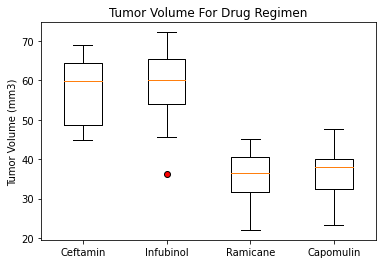

In [53]:
outlier_marker ={'markerfacecolor':'r', 'marker':'o'}

# Plot boxplots
fig, ax = plt.subplots()
ax.set_title('Tumor Volume For Drug Regimen')
ax.set_xticklabels(plot_list.keys())
ax.set_ylabel('Tumor Volume (mm3)')
ax.boxplot(plot_list.values(), flierprops=outlier_marker)
plt.show()

## Line and Scatter Plots

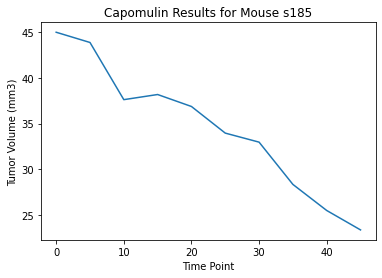

In [54]:
# Filtes single mouse (s185)
s185_df = study_data_df.loc[study_data_df['Mouse ID'] == 's185']

tumor_volume = s185_df['Tumor Volume (mm3)']
time_point = s185_df['Timepoint']

plt.plot(time_point, tumor_volume)
plt.title('Capomulin Results for Mouse s185')
plt.xlabel('Time Point')
plt.ylabel('Tumor Volume (mm3)')
plt.show()

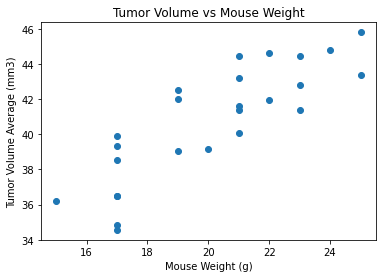

In [55]:
capomulin_df = study_data_df.loc[study_data_df['Drug Regimen'] == 'Capomulin']

avg_tumor_size = capomulin_df.groupby('Mouse ID')['Tumor Volume (mm3)'].mean()
mouse_weight = capomulin_df.groupby('Mouse ID')['Weight (g)'].max()

# Plot scatter plot
plt.scatter(mouse_weight, avg_tumor_size)
plt.xlabel('Mouse Weight (g)')
plt.ylabel('Tumor Volume Average (mm3)')
plt.title('Tumor Volume vs Mouse Weight')
plt.show()

## Correlation and Regression

r-value: 0.8419363424694718
r-squared value: 0.7088568047708717


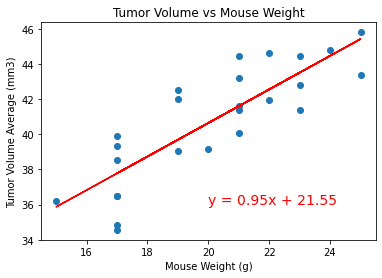

In [56]:
# get regression values
(slope, intercept, rvalue, pvalue, stderr) = linregress(mouse_weight, avg_tumor_size)
regress_values = mouse_weight * slope + intercept
line_eq = 'y = ' + str(round(slope, 2)) + 'x + ' + str(round(intercept, 2))

print(f'r-value: {rvalue}')
print(f'r-squared value: {rvalue ** 2}')

# Plot tumor volume vs mouse weight with regression info
plt.scatter(mouse_weight, avg_tumor_size)
plt.plot(mouse_weight, regress_values, 'r-')
plt.annotate(line_eq, (20, 36), fontsize=14, color='red')
plt.xlabel('Mouse Weight (g)')
plt.ylabel('Tumor Volume Average (mm3)')
plt.title('Tumor Volume vs Mouse Weight')
plt.show()

## Comparison of Mice Ages between Drug Regimens

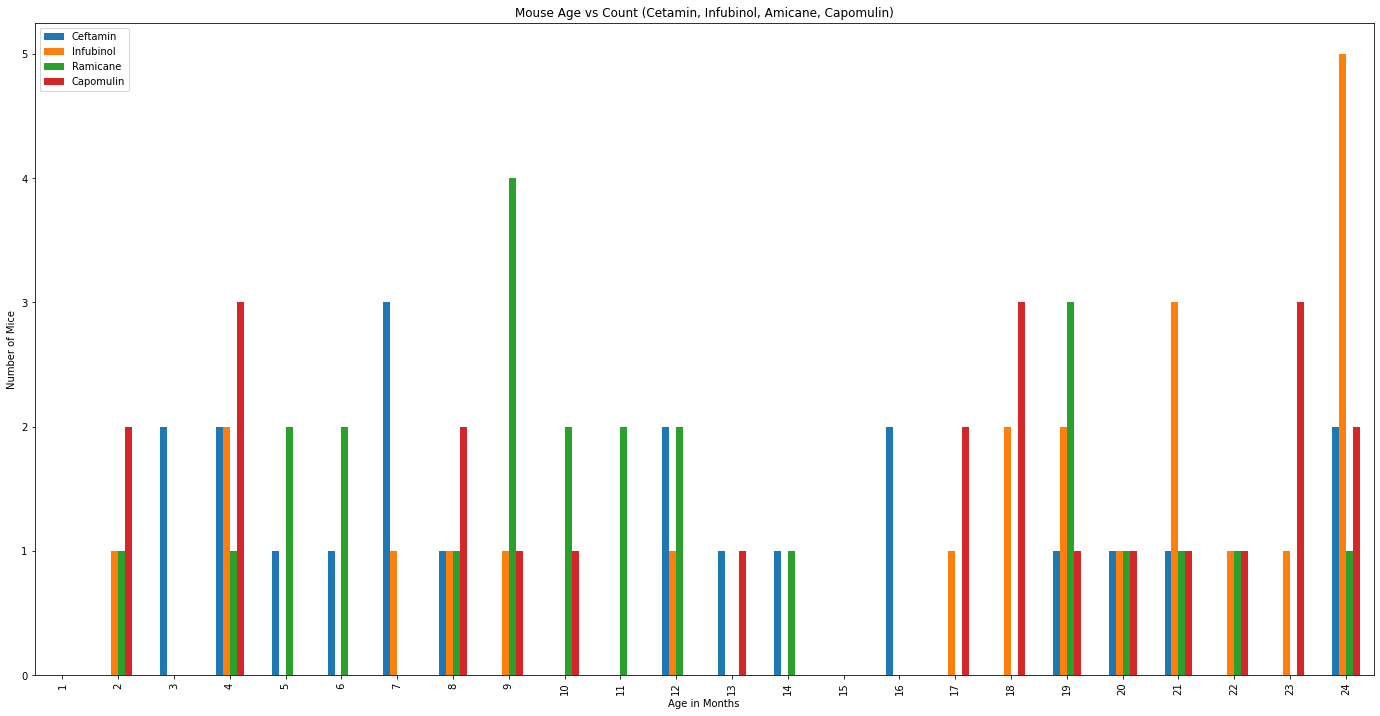

In [57]:
# Added to illustrate that the experiment isn't controlled for mouse age
months = np.arange(1, 25)
mouse_age_df = pd.DataFrame({
    'mouse_age_months': months
})

for drug in drug_list:
    mice_age_df = study_data_df.loc[study_data_df['Drug Regimen'] == drug]
    mice_age = mice_age_df.groupby('Age_months')['Mouse ID'].nunique()
    mouse_age_df[drug] = mice_age

mouse_age_df.fillna(0, inplace=True)
mouse_age_df.plot.bar(x='mouse_age_months', y= drug_list, figsize = (24, 12), ylabel = 'Number of Mice', xlabel='Age in Months')
plt.title('Mouse Age vs Count (Cetamin, Infubinol, Amicane, Capomulin)')
plt.show()


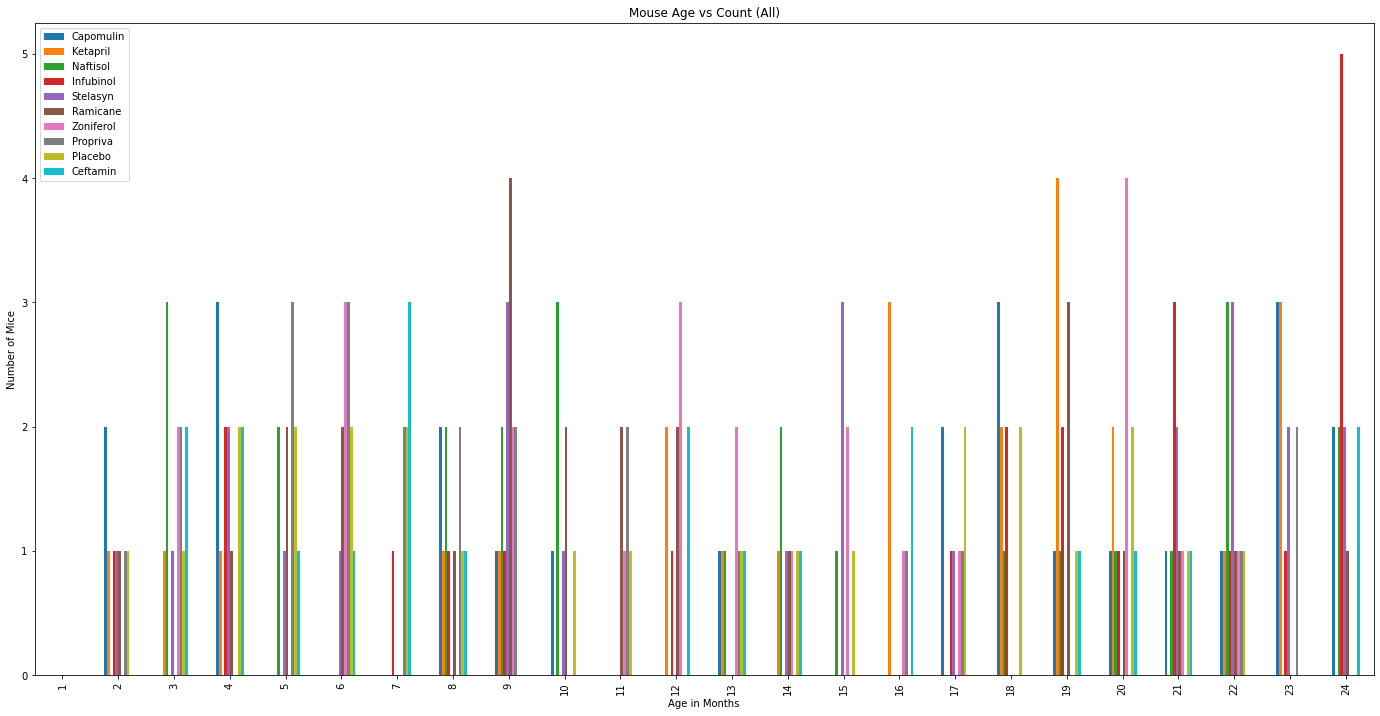

In [58]:
months = np.arange(1, 25)
mouse_age_df = pd.DataFrame({
    'mouse_age_months': months
})

drug_list = study_data_df['Drug Regimen'].unique()

for drug in drug_list:
    mice_age_df = study_data_df.loc[study_data_df['Drug Regimen'] == drug]
    mice_age = mice_age_df.groupby('Age_months')['Mouse ID'].nunique()
    mouse_age_df[drug] = mice_age

mouse_age_df.fillna(0, inplace=True)
mouse_age_df.plot.bar(x='mouse_age_months', y= drug_list, figsize = (24, 12), ylabel = 'Number of Mice', xlabel='Age in Months')
plt.title('Mouse Age vs Count (All)')
plt.show()